In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from glob import glob
import numpy as np
import math

import sys
sys.path.append("../")

# Imports
import numpy as np
np.float = float

from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.adwin import ADWIN


In [3]:
def get_cm_detections(altered_sg_batch, method_warnings):
    """
    Returns the confusion matrix for the detections of a method
    Args:
        altered_sg_batch: list of altered subgroups per batch
        method_warnings: dict of batch_idx: list of warnings or detections
    Returns:    
        tp, fp, fn, tn
    
    """
    tp, fp, fn, tn = 0, 0, 0, 0

    for batch_idx in range(1, len(altered_sg_batch)):    
        num_altered = altered_sg_batch[batch_idx]
        if batch_idx in method_warnings:
            num_warnings = len(method_warnings[batch_idx])
        else:
            num_warnings = 0

        # Altered and detected
        if num_altered>0 and num_warnings>0:
            tp+=1
        elif num_altered==0 and num_warnings>0:
            fp+=1
        elif num_altered>0 and num_warnings==0:
            fn+=1
        else:
            tn+=1
    return tp, fp, fn, tn

In [4]:
ckpt_dir = '/home/fgiobergia/div-mitigation/models-ckpt'

In [5]:
checkpoint = "xgb-adult"
metric = "accuracy"
frac = 0.5

target_files = glob(f"{ckpt_dir}/{checkpoint}-{metric}-noise-{frac:.2f}/target*pkl")

In [6]:
import pathlib

output_dir = os.path.join('results-drift-overall',f'{checkpoint}-{metric}-noise-{frac:.2f}')
p = pathlib.Path(output_dir)
p.mkdir(parents=True, exist_ok=True)

In [7]:
for tgt_idx, tgt in enumerate(target_files):

    subgroup_config_name = tgt.split('target-')[1].replace('.pkl', '')

    with open(tgt, "rb") as f:
        obj = pickle.load(f)
        sg = frozenset(obj["subgroup"])
        accuracies = obj["accuracies"]
        f1 = obj["f1"]
        divs = obj["divs"]
        y_trues = obj["y_trues"]
        y_preds = obj["y_preds"]
        noise_fracs = obj["noise_fracs"]
        altered = obj["altered"]


    matches_filename = os.path.join(ckpt_dir, f"matches-{checkpoint}.pkl")
    with open(matches_filename, "rb") as f:
        matches_obj = pickle.load(f)
        df_train = matches_obj["metadata_train"]
        df_tests = matches_obj["metadata_batches"]
        matches = matches_obj["matches_train"]
        matches_ts_list = matches_obj["matches_batches"]


    # Support
    dataset_len = sum([df_tests[i].shape[0] for i in range(len(df_tests))])
    support_sg = matches.fi.set_index("itemsets").loc[[sg ]].sort_values("support", ascending=False)['support'].values[0]
    support_count_sg = math.ceil(support_sg*dataset_len)

    # Total altered
    altered_sg_batch =  [(altered[i]==True).astype(int).sum() for i in range(len(altered))]
    altered_sg = sum(altered_sg_batch)




    # Detect overall drift with DDM and ADWIN

    ddm = DDM(min_num_instances=500)
    adwin = ADWIN()

    batch_idx = 0

    dmm_warnings = {}
    dmm_detected = {}
    adwin_detected = {}
    adwin_warnings = {}

    for batch_idx in range(len(y_trues)):
        # DMM: This parameter indicates whether the last sample analyzed was correctly classified or not. 1 indicates an error (miss-classification).
        errors_b = (y_trues[batch_idx]!=y_preds[batch_idx]).astype(int)
        # ADWIN: 0: Means the learners prediction was wrong 1: Means the learners prediction was correct
        correct_b = (y_trues[batch_idx]==y_preds[batch_idx]).astype(int)
        for i in range(len(errors_b)):
            ddm.add_element(errors_b[i])
            
            # Start detecting change after the first batch
            if batch_idx>=1:
                if ddm.detected_warning_zone():
                    if batch_idx not in dmm_warnings:
                        dmm_warnings[batch_idx] = []
                    dmm_warnings[batch_idx].append(i)
                    #print('Warning zone has been detected in data: ' + str(errors_b[i]) + ' - of index: ' + str(i))
                if ddm.detected_change():
                    print(f'DMM {tgt_idx} - Change has been detected in data: {errors_b[i]} - of index: {i}')
                    if batch_idx not in dmm_detected:
                        dmm_detected[batch_idx] = []
                    dmm_detected[batch_idx].append(i)


            adwin.add_element(correct_b[i])
            # Start detecting change after the first batch
            if batch_idx>=1:
                if adwin.detected_change():
                    print(f'ADWIN  {tgt_idx} - Change has been detected in data: {correct_b[i]} - of index: {i}')
                    if batch_idx not in adwin_detected:
                        adwin_detected[batch_idx] = []
                    adwin_detected[batch_idx].append(i)
                if adwin.detected_warning_zone():
                    #print('Warning in data: ' + str(correct_b[i]) + ' - at index: ' + str(i))
                    if batch_idx not in adwin_warnings:
                        adwin_warnings[batch_idx] = []
                    adwin_warnings[batch_idx].append(i)

    # Store subgroup results
    overall_drift_result = {
        'subgroup': sg,
        'altered_sg': altered_sg,
        'support_sg': support_sg,
        'support_count_sg': support_count_sg,
        'dmm_warnings': get_cm_detections(altered_sg_batch, dmm_warnings),
        'dmm_detected': get_cm_detections(altered_sg_batch, dmm_detected),
        'adwin_detected': get_cm_detections(altered_sg_batch, adwin_detected),
        'adwin_warnings': get_cm_detections(altered_sg_batch, adwin_warnings),   
        'dmm_detected_batch': dmm_detected,
        'adwin_detected_batch': adwin_detected,
        }
    
    with open(os.path.join(output_dir, f"overalldrift-{subgroup_config_name}.pkl"), "wb") as f:
        pickle.dump(overall_drift_result, f)

DMM 0 - Change has been detected in data: 1 - of index: 518
DMM 4 - Change has been detected in data: 1 - of index: 738
DMM 7 - Change has been detected in data: 1 - of index: 101
DMM 8 - Change has been detected in data: 1 - of index: 313
ADWIN  8 - Change has been detected in data: 1 - of index: 637
DMM 11 - Change has been detected in data: 1 - of index: 40
DMM 18 - Change has been detected in data: 1 - of index: 743
DMM 19 - Change has been detected in data: 1 - of index: 68
DMM 22 - Change has been detected in data: 1 - of index: 679
DMM 25 - Change has been detected in data: 1 - of index: 654
DMM 25 - Change has been detected in data: 1 - of index: 701
ADWIN  25 - Change has been detected in data: 1 - of index: 761
ADWIN  25 - Change has been detected in data: 0 - of index: 65
DMM 26 - Change has been detected in data: 1 - of index: 241
DMM 31 - Change has been detected in data: 1 - of index: 384
DMM 32 - Change has been detected in data: 1 - of index: 743
DMM 35 - Change has bee

In [8]:
output_files = glob(f"{output_dir}/*pkl")

In [21]:
supports = []
precisions = []
recalls = []
f1s = []
detecteds = []
tps = []
method = 'dmm'
for e, output_file in enumerate(output_files):

    with open(output_file, "rb") as f:
        obj = pickle.load(f)
    tp, fp, fn, tn = obj[f'{method}_detected']
    precision = tp / (tp + fp) if (tp + fp)>0 else 0
    recall = tp / (tp + fn)
    f1 = 2 *tp / (2*tp + fp + fn)
    tps.append(tp)
    supports.append(obj['support_sg'])
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    detecteds.append(1 if len(obj[f'{method}_detected_batch'])>0 else 0)



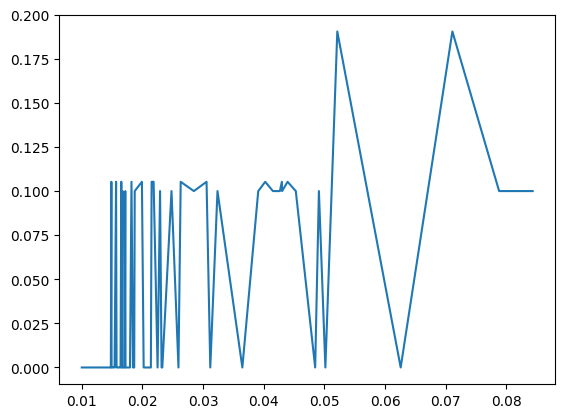

In [22]:
import matplotlib.pyplot as plt

idx_sorted = np.argsort(supports)
f1s_sorted = np.array(f1s)[idx_sorted]
supports_sorted = np.array(supports)[idx_sorted]

plt.plot(supports_sorted, f1s_sorted)



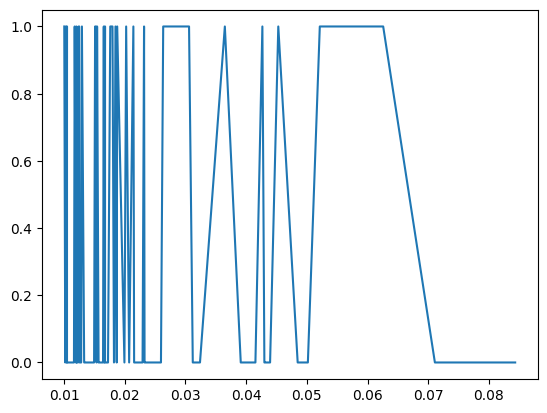

In [23]:
import matplotlib.pyplot as plt

idx_sorted = np.argsort(supports)
detecteds_dmm_sorted = np.array(detecteds)[idx_sorted]
supports_sorted = np.array(supports)[idx_sorted]

plt.plot(supports_sorted, detecteds)



In [24]:
sum(detecteds)/len(detecteds)

0.29